In [1]:
import psycopg2
from IPython.display import Image
import copy
import json
import pydot

from tree_node import TreeNode
from qep_stats import * 
from parse_tree import parseJsonNode, getTreeBFS

In [2]:
def connect(query):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        host='localhost' #'172.21.148.168'
        database='classicmodels'
        user='signapoop' #'db'
        password='none' #'dbproj'
 
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(host=host,database=database, user=user, password=password)

        cur = conn.cursor()
        cur.execute(query)
        result = cur.fetchall()
        
        # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return result

In [3]:
# query = \
# "EXPLAIN(ANALYZE, FORMAT JSON) \
# SELECT c.customerNumber, COUNT(*) \
# FROM customers c, orders o, orderdetails od \
# WHERE c.customerNumber = o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 \
# GROUP BY c.customerNumber \
# HAVING COUNT(*) > 4;"

In [4]:
query = \
"EXPLAIN(FORMAT JSON) \
SELECT c.customerNumber, COUNT(*) \
FROM customers c, orders o, orderdetails od \
WHERE c.customerNumber > o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 + 3 \
GROUP BY c.customerNumber \
HAVING COUNT(*) > 4"

In [5]:
# query = \
# "EXPLAIN (ANALYZE, FORMAT JSON)\
# SELECT o.officecode, o.city, COUNT(*) \
# FROM employees c, offices o \
# WHERE c.officecode = o.officecode \
# GROUP BY o.officecode \
# HAVING COUNT(*) > 1;"

In [6]:
result = connect(query)

Connecting to the PostgreSQL database...
Database connection closed.


In [7]:
print(json.dumps(result[0][0], sort_keys=True, indent=4))

[
    {
        "Plan": {
            "Filter": "(count(*) > 4)",
            "Group Key": [
                "c.customernumber"
            ],
            "Node Type": "Aggregate",
            "Parallel Aware": false,
            "Partial Mode": "Simple",
            "Plan Rows": 41,
            "Plan Width": 16,
            "Plans": [
                {
                    "Hash Cond": "(od.ordernumber = o.ordernumber)",
                    "Inner Unique": false,
                    "Join Type": "Inner",
                    "Node Type": "Hash Join",
                    "Parallel Aware": false,
                    "Parent Relationship": "Outer",
                    "Plan Rows": 121834,
                    "Plan Width": 8,
                    "Plans": [
                        {
                            "Alias": "od",
                            "Filter": "(quantityordered > 4)",
                            "Node Type": "Seq Scan",
                            "Parallel Aware": false,


In [8]:
def plotBFS(root, graph):
    frontier = [root]
    i = 0
    while frontier:
        next_level = []
        for u in frontier:
            #print("level {}, val {}, title {}".format(i, n.val, n.title))
            for v in u.children: 
                edge = pydot.Edge(u.pydot_node, v.pydot_node)
                graph.add_edge(edge)
                next_level.append(v)
        frontier = next_level
        i += 1

def plotQueryTree(query, qep, filename='test.png'):
    assert 'Plan' in qep[0], "Invalid JSON was given"
    root = parseJsonNode(qep[0]['Plan'])
    all_nodes = getTreeBFS(root)
    
    # Compute statistics
    execution_time = qep[0].get('Execution Time', None)
    planning_time = qep[0].get('Planning Time', None)
    calculateActualCost(all_nodes)
    calculateActualDuration(all_nodes)
    largest_row = markLargestNode(all_nodes)
    largest_cost = markCostliestNode(all_nodes)
    largest_duration = markSlowestNode(all_nodes)
    calculatePercentDuration(all_nodes, execution_time)
    
    correlateQuery(all_nodes, query)
    
    stats = {'execution_time': execution_time, 
             'planning_time': planning_time,
             'largest_row': largest_row, 
             'largest_cost': largest_cost, 
             'largest_duration': largest_duration}
    
    graph = pydot.Dot(graph_type='graph')
    for node in all_nodes:
        node.pydot_node = pydot.Node(node.to_string(), shape='box')
        graph.add_node(node.pydot_node)
    plotBFS(all_nodes[0], graph)
    graph.write_png(filename)
    return filename, all_nodes, stats

In [9]:
def stripParenthesis(foo):
    if foo[0]=='(' and foo[-1]==')':
        return foo[1:-1]

In [10]:
def findMatchingBE(query, booleans, cond):
    for b in booleans:
        be = BooleanExpression(cond, variables=b.variables, rev_variables=b.rev_variables)
        if isEquivalentBooleanExpression(be, b):
            return b.start, b.end, query[b.start:b.end]
    return -1, -1, ""

In [11]:
from findExpressions import *
from BooleanExpression import BooleanExpression

In [13]:
def reverseComparatorIfNeeded(comparator):
    if comparator == '<':
        return '>'
    elif comparator == '<=':
        return '>='
    return comparator

def isEquivalentBooleanExpression(a,b):
    if a.left.exp==b.left.exp and a.right.exp==b.right.exp:
        return a.comparator==b.comparator
    elif a.left.exp==b.right.exp and a.right.exp==b.left.exp:
        return a.comparator==reverseComparatorIfNeeded(b.comparator)
    
    return False

In [14]:
def getMatchingClause(query, search_key):
    start = query.find(search_key)
    if start == -1:
        return start
    shortened_query = query[start+len(search_key)+1:]
    parts = shortened_query.split(' ') 
    return search_key + ' ' + parts[0]

In [15]:
def findClauseStartEnd(query, clause):
    start = query.find(clause)
    if start == -1:
        return -1, -1, ""
    return start, start + len(clause), clause

In [16]:
def correlateQuery(all_nodes, query):
    # Change query to a list of Boolean expressions
    booleans = findExpressions(query)
    
    for node in all_nodes:
        #print(node.title)
        s = -1
        e = -1
        if 'Join' in node.title:
            # Find hash condition as boolean expression
            cond = stripParenthesis(node.description_dict['Hash Cond'])
            s, e, match = findMatchingBE(query, booleans, cond)
            print('Join:', cond, 'Matched: ', match)
            
        elif 'Scan' in node.title:
            # Find relation name
            clause = " ".join([node.description_dict['Relation Name'], node.description_dict['Alias']])
            s, e, match = findClauseStartEnd(query, clause)
            print('Scan:', clause, 'Matched: ', match)
            if 'Filter' in node.description_dict:
                # Find filter condition as boolean expression
                cond = stripParenthesis(node.description_dict['Filter'])
                s, e, match = findMatchingBE(query, booleans, cond)
                print('Filter:', cond, 'Matched: ', match)
                
        elif 'Aggregate' in node.title:
            # Find GROUP BY
            clause = getMatchingClause(query, 'GROUP BY')
            s, e, match = findClauseStartEnd(query, clause)
            print('Aggregate:', 'Matched: ', match)
        
        elif 'Sort' in node.title:
            clause = getMatchingClause(query, 'ORDER BY')
            s, e, match = findClauseStartEnd(query, clause)
            print('Sort:', 'Matched: ', match)
            
        node.description_dict['StartOfQuery'] = s
        node.description_dict['EndOfQuery'] = e
        
#correlateQuery(all_nodes, query)

In [17]:
qep = result[0][0]
filename, all_nodes, stats = plotQueryTree(query, qep)
print(stats)

Aggregate: Matched:  GROUP BY c.customerNumber
Join: od.ordernumber = o.ordernumber Matched:  o.orderNumber = od.orderNumber
Scan: orderdetails od Matched:  orderdetails od
Filter: quantityordered > 4 Matched:  od.quantityOrdered > 1 + 3
Scan: customers c Matched:  customers c
Scan: orders o Matched:  orders o
{'execution_time': None, 'planning_time': None, 'largest_row': 121834, 'largest_cost': 1545.0900000000001, 'largest_duration': None}


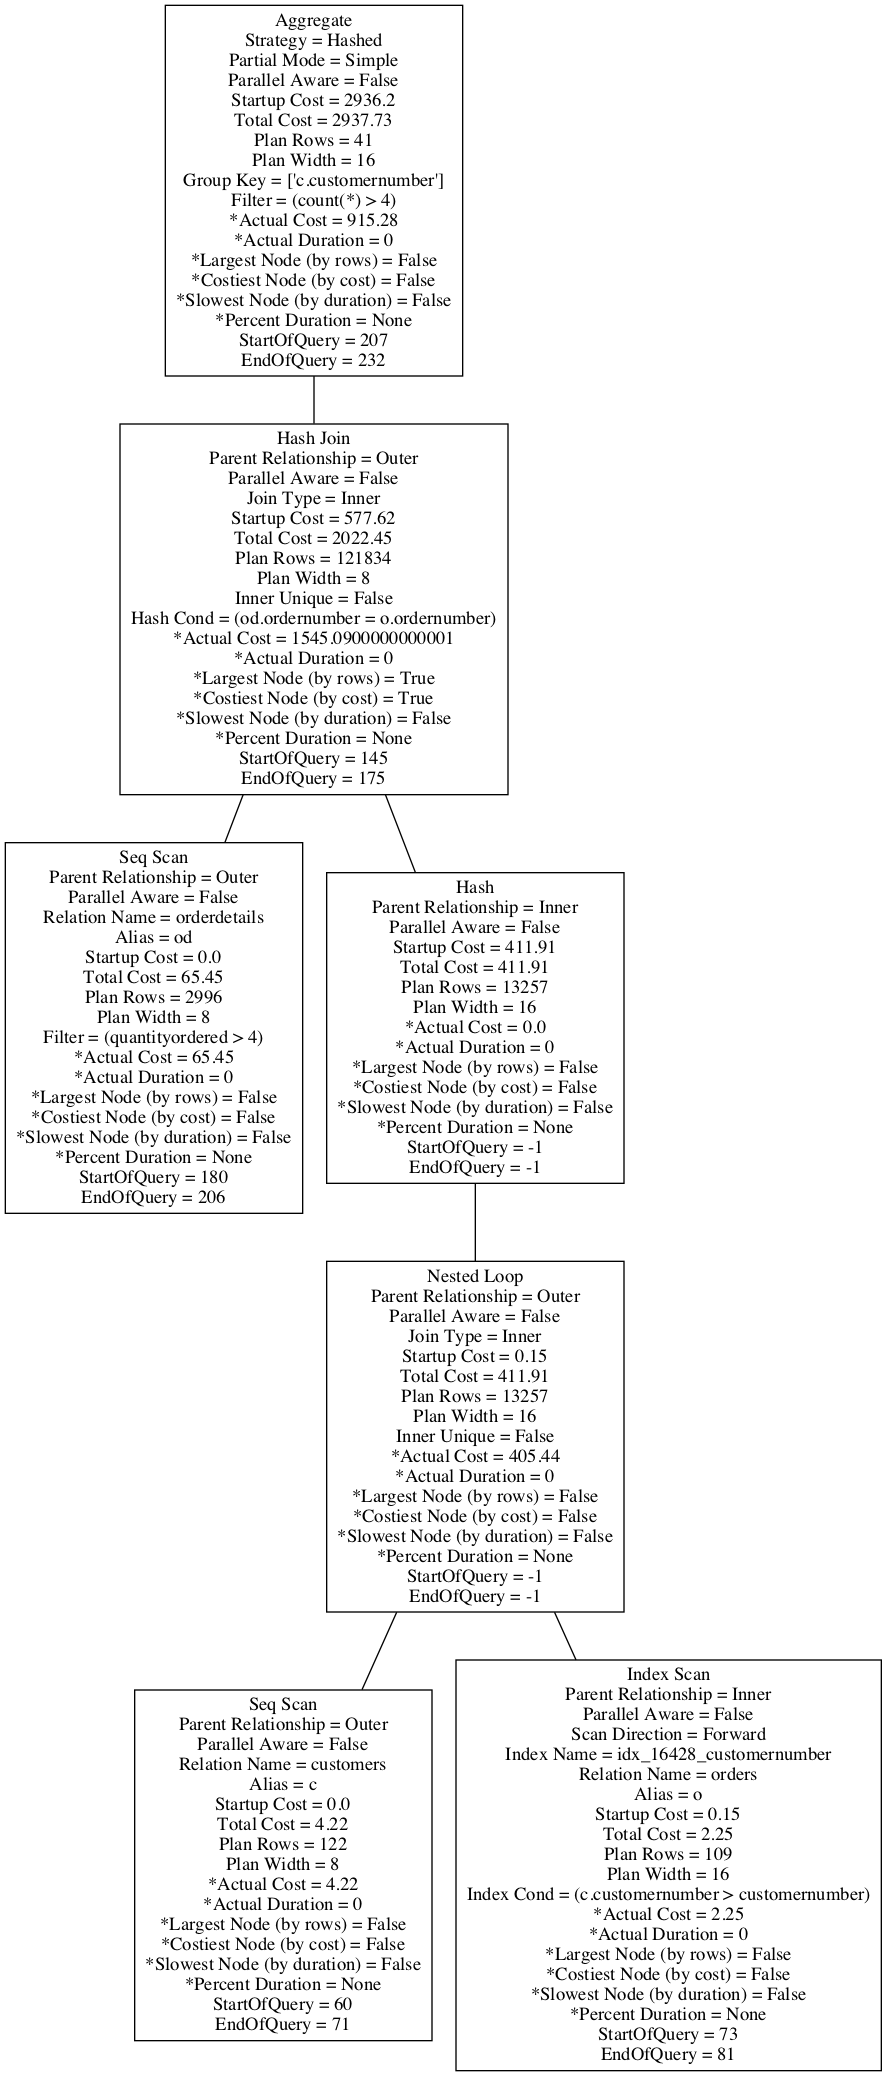

In [18]:
Image(filename)

In [19]:
with open('stats.json', 'w') as outfile:
    json.dump(stats, outfile)

with open('qep.json', 'w') as outfile:
    json.dump(all_nodes[0].to_json(), outfile, indent=4)